# HW 2 - Naive Bayes in Hadoop MR
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the live sessions for week 2 and week 3 you got some practice designing and debugging Hadoop Streaming jobs. In this homework we'll use Hadoop MapReduce to implement your first parallelized machine learning algorithm: Naive Bayes. As you develop your implementation you'll test it on a small dataset that matches the 'Chinese Example' in the _Manning, Raghavan and Shutze_ reading for Week 2. For the main task in this assignment you'll be working with a small subset of the Enron Spam/Ham Corpus. By the end of this assignment you should be able to:
* __... describe__ the Naive Bayes algorithm including both training and inference.
* __... perform__ EDA on a corpus using Hadoop MR.
* __... implement__ parallelized Naive Bayes.
* __... constrast__ partial, unordered and total order sort and their implementations in Hadoop Streaming.
* __... explain__ how smoothing affects the bias and variance of a Multinomial Naive Bayes model.

As always, your work will be graded both on the correctness of your output and on the clarity and design of your code. __Please refer to the `README` for homework submission instructions.__ 

## Notebook Setup
Before starting, run the following cells to confirm your setup.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/HW2/"
HOME_DIR = "/media/notebooks/Assignments/HW2" # FILL IN HERE eg. /media/notebooks/Assignments/HW2

In [3]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [4]:
# data path
ENRON = "data/enronemail_1h.txt"

In [5]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -ls 
!hdfs dfs -mkdir {HDFS_DIR}

Found 1 items
drwxr-xr-x   - root supergroup          0 2020-01-28 19:47 demo3


# Question 1: Hadoop MapReduce Key Takeaways.  

This assignment will be the only one in which you use Hadoop Streaming to implement a distributed algorithm. The key reason we continue to teach Hadoop streaming is because of the way it forces the programmer to think carefully about what is happening under the hood when you parallelize a calculation. This question will briefly highlight some of the most important concepts that you need to understand about Hadoop Streaming and MapReduce before we move on to Spark next week.   

### Q1 Tasks:

* __a) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __b) short response:__ What is the Hadoop Shuffle? When does it happen? Why is it potentially costly? Describe one specific thing we can we do to mitigate the cost associated with this stage of our Hadoop Streaming jobs.

* __c) short response:__ In Hadoop Streaming why do the input and output record format of a combiner script have to be the same? [__`HINT`__ _what level of combining does the framework guarantee? what is the relationship between the record format your mapper emits and the format your reducer expects to receive?_]

* __d) short response:__ To what extent can you control the level of parallelization of your Hadoop Streaming jobs? Please be specific.

* __e) short response:__ What change in the kind of computing resources available prompted the creation of parallel computation frameworks like Hadoop? 

### Q1 Student Answers:

> __a)__ MapReduce is based on the functional programming paradigm. First, it uses a declarative programming approach, which means that the programming is represented as expressions. The two main expresssions in Hadoop MapReduce are 'map', where we transform input into key/value pairs, and 'reduce', where we aggregate (fold) those key/value pairs. Second, in functional programming, functions are first-class objects, meaning the a function can take a function as an argument.  This allows output from one function to be input to the next.  With this model, we avoid/minimize sharing state on mutable data. Hadoop MapReduce exemplifies this approach by performing all processing in the 'map' and 'reduce' tasks; the output of map is input to reduce.


> __b)__ The Hadoop shuffle phase is the likely the most complex portion of the MapReduce job.  Shuffling is responsible to receiving the output from the mappers, performing the partitioning to route records to particular instance of the reducers, sorting, so that each partition is sorted by the specified key.  This involve mechanisms by which the output from the mappers is stored in a buffer and then "spilled" onto disk once its buffer size is exceeded.  During this process, the partitions are maintained such that the correct key/value records are designated to the correct partition.  After all key/value records have been processed from all mappers, the records within each partition can be sorted by the specified sort key.  This is an expensive operation, both due to the complexity of coordination, the cost of sorting, and the network I/O cost of routing the key/value pairs to reducers on different nodes.

> __c)__ Combiners are optional, so at runtime, they may or may not run after the mapper; therefore, we need to guarantee that the output from the mapper is in the same format it would be either when the combiner was run or when it was not run.  Then, the reducer (and the shuffler) can depend on a consistent input.

> __d)__ We achieve parallelization in 2 ways with MapReduce, first, by running multiple mappers over "splits" of the data, and second by running multiple reducers over partitions of the data.  MapReduce jobs can take an arguments for the number of splits, but this is only a suggestion.  MapReduce will typically split input files into 16 megabytes to 64 megabytes (MB) per pieces, so the number of mappers running in parallel is determined by designated sizes of these pieces. (This can be configured via DFS block size to adjust the number of maps.) The number of reducers can be specified to the MapReduce job via the "number of reduces tasks" and as such, we are in control over how many reducers can run in parallel.  Of course, acheiving parallelization also requires a sufficiently resourced compute environment so that these parallel jobs can run without "pegging" the node instances, either due to CPU, network, or disk I/O bottlenecks.

> __e)__ When "commodity" servers became reasonable priced, this ushered in an era of scaling "out" rather than scaling "up".  Scaling out means running on many "commodity" machines rather than running on a few expensive large compute machines.  Since we are likely to see more failures with a large number of commodity machines, the MapReduce paradigm has robust mechanisms for dealing with failures. As such, the MapReduce framework distributes the data across redundant nodes and can handle failures by retrying the task, or re-routing the map or reduce task to another node.

# Question 2: MapReduce Design Patterns.  

In the last two live sessions and in your readings from Lin & Dyer you encountered a number of techniques for manipulating the logistics of a MapReduce implementation to ensure that the right information is available at the right time and location. In this question we'll review a few of the key techniques you learned.   

### Q2 Tasks:

* __a) short response:__ What are counters (in the context of Hadoop Streaming)? How are they useful? What kinds of counters does Hadoop provide for you? How do you create your own custom counter?

* __b) short response:__ What are composite keys? How are they useful? How are they related to the idea of custom partitioning?

* __c) short response:__ What is the order inversion pattern? What problem does it help solve? How do we implement it? 

### Q2 Student Answers:

> __a)__ In Hadoop Streaming, counters are lightweight objects that you can use keep track of system progress in your mappers and reducers.  This can be very helpful for troubleshooting problems or investigating the internal workings of your MapReduce job.  For example, a counter could be used to report the number of 'error' records to detect data health or a counter could be used to report the number of I/O operations to get a sense of bottlenecks and areas that require some tuning.


> __b)__ Composite keys are keys comprised of multiple tokens. This allows us to sort by the primary key, and then with all values of a primary key, sort on a secondary key, and so one.  For MapReduce jobs, we use composite keys for partitioning where the primary key is the partition key and the secondary key is the key we want to sort the records by for a given paritition.  Composite keys would also allow us to 'sort by value', which will will force an order for the values belonging to one key. 

> __c)__ The order inversion pattern leverages partitioning and sorting so that the reducer can access a computation (usually an aggregration) before processing each of the data records, thus requiring only one pass through the key/value pairs in the reducers.  The order inversion pattern involves assigning a key to these "computed" values that we are assured will always sort before all of the other keys.  For example, to compute word frequency, we need the total number of words in the document before we process any of the individual word counts.  To accomplish this we perform aggregation and emit the same "total" records to every partition.  We devise a key for the "total" records that will ensure that it always sorts before the data records.  Then, each partition has the same "total" records, sorted at the top.  Then the reducer can aggregate these totals and use them during the processing of the data records.


# Question 3: Understanding Total Order Sort

The key challenge in distributed computing is to break a problem into a set of sub-problems that can be performed without communicating with each other. Ideally, we should be able to define an arbirtary number of splits and still get the right result, but that is not always possible. Parallelization becomes particularly challenging when we need to make comparisons between records, for example when sorting. Total Order Sort allows us to order large datasets in a way that enables efficient retrieval of results. Before beginning this assignment, make sure you have read and understand the [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb). You can skip the first two MRJob sections, but the rest of section III and all of section IV are **very** important (and apply to Hadoop Streaming) so make sure to read them closely. Feel free to read the Spark sections as well but you won't be responsible for that material until later in the course. To verify your understanding, answer the following questions.

### Q3 Tasks:

* __a) short response:__ What is the difference between a partial sort, an unordered total sort, and a total order sort? From the programmer's perspective, what does total order sort allow us to do that we can't with unordered total? Why is this important with large datasets?

* __b) short response:__ Which phase of a MapReduce job is leveraged to implement Total Order Sort? Which default behaviors must be changed. Why must they be changed?

* __c) short response:__ Describe in words how to configure a Hadoop Streaming job for the custom sorting and partitioning that is required for Total Order Sort.  

* __d) short response:__ Explain why we need to use an inverse hash code function.

* __e) short response:__ Where does this function need to be located so that a Total Order Sort can be performed?

### Q3 Student Answers:

> __a)__ With a partial sort, the records are sorted (by key) **within** each partition.  With an unordered total sort, the records are sorted (by key) **across** all partitions (but not between partitions). With a total sort order the records are sorted **across** all partitions **and** the partition file names are also assigned in order. With a total sort order, we can iterate over the HDFS partitions by index and be guaranteed that we are processing the records in order.  For large datasets, we need to 'divide and conquer' so it could be that a dataset by split into many smaller chunks and wouldn't be scalable to then send all of these key/value pairs into a single reducer to guarantee total sort order.  So we want to run multiple reducers and at the same time maintain a sort order across all of the partitions.  This is important when we need to get the "top" values for a large document or a large set of documents. Then we can just go to the first partition and know we are getting the top records across the entire dataset.

> __b)__ To implement Total Sort Order, we leverage the 'shuffle' phase, introducing a partition key that will preserve sort order across all of the partitions.  We must replace the default partition behavior with a custom partitioner (in the mapper) that assigns a partition key based on the natural sort order that will preserve sort order across partitions.  This custom partion key generation is performed in the mapper.  Furtherore, to acheive total sort order (without post-reducer processing), we need perform inverse hash on these keys so that the internal partition index will be ordered in the same way as our partition key. 

> __c)__ To acheive total sort order in the Hadoop streaming job, the mappers generate a partition key based on the natural sort order.  This partition key must then be transformed via an inverse hash so that the parition index order corresponds to the partition key.  This parition key will ensure that all records in one partition represent a "section" of key-value pairs (in continguous sequence across the entire set of records). During the shuffle phase, via Hadoop streaming parameters, we will specify which field is used as the partition key and which field or fields should be used to sort the key/value pairs.  The first key will be the partition key and the second key will be the natural order key. Then in the reducer(s), this parition key is dropped.  The reducers will each write a partition file, named by the partition index.  At this point, we have a total sort order because the partitions can be read in order and reflect the order of the original partition key.  For the Hadoop streaming job we must specify a) that we are using a custom partitioner, b) what field is the partition key, c) how many reducers, which should match the number of partition keys) and d) the composite key for ordering, which is the partition key and the field that we want to sort the key/value pairs by.

> __d)__ An inverse hash function will allow us to preserve partition key sorting so that the partition index assigned by Hadoop will correspond to the same order as the partition keys. For example, if we want to sort partition key A before B, partition key of A will be inverse hashed so that its value, when hashed by Hadoop, will output 0; the inverse hash of partition B will output a 1 when hashed by Hadoop.

> __e)__ To acheive total sort order, we need the partion files to be ordered the same way as the natural order partion key. This function must reside in the mapper and be performed on each partition key so these keys are "transformed" before being emitted as the partition key.

# About the Data
For the main task in this portion of the homework you will train a classifier to determine whether an email represents spam or not. You will train your Naive Bayes model on a 100 record subset of the Enron Spam/Ham corpus available in the HW2 data directory (__`HW2/data/enronemail_1h.txt`__).

__Source:__   
The original data included about 93,000 emails which were made public after the company's collapse. There have been a number raw and preprocessed versions of this corpus (including those available [here](http://www.aueb.gr/users/ion/data/enron-spam/index.html) and [here](http://www.aueb.gr/users/ion/publications.html)). The subset we will use is limited to emails from 6 Enron employees and a number of spam sources. It is part of [this data set](http://www.aueb.gr/users/ion/data/enron-spam/) which was created by researchers working on personlized Bayesian spam filters. Their original publication is [available here](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf). __`IMPORTANT!`__ _For this homework please limit your analysis to the 100 email subset which we provide. No need to download or run your analysis on any of the original datasets, those links are merely provided as context._

__Preprocessing:__  
For their work, Metsis et al. (the authors) appeared to have pre-processed the data, not only collapsing all text to lower-case, but additionally separating "words" by spaces, where "words" unfortunately include punctuation. As a concrete example, the sentence:  
>  `Hey Jon, I hope you don't get lost out there this weekend!`  

... would have been reduced by Metsis et al. to the form:  
> `hey jon , i hope you don ' t get lost out there this weekend !` 

... so we have reverted the data back toward its original state, removing spaces so that our sample sentence would now look like:
> `hey jon, i hope you don't get lost out there this weekend!`  

Thus we have at least preserved contractions and other higher-order lexical forms. However, one must be aware that this reversion is not complete, and that some object (specifically web sites) will be ill-formatted, and that all text is still lower-cased.


__Format:__   
All messages are collated to a tab-delimited format:  

>    `ID \t SPAM \t SUBJECT \t CONTENT \n`  

where:  
>    `ID = string; unique message identifier`  
    `SPAM = binary; with 1 indicating a spam message`  
    `SUBJECT = string; title of the message`  
    `CONTENT = string; content of the message`   
    
Note that either of `SUBJECT` or `CONTENT` may be "NA", and that all tab (\t) and newline (\n) characters have been removed from both of the `SUBJECT` and `CONTENT` columns.  

In [6]:
!pwd

/media/notebooks/Assignments/HW2


In [7]:
# take a look at the first 100 characters of the first 5 records (RUN THIS CELL AS IS)
!head -n 5 /media/notebooks/Assignments/HW2/{ENRON} | cut -c-100

0001.1999-12-10.farmer	0	 christmas tree farm pictures	NA
0001.1999-12-10.kaminski	0	 re: rankings	 thank you.
0001.2000-01-17.beck	0	 leadership development pilot	" sally:  what timing, ask and you shall receiv
0001.2000-06-06.lokay	0	" key dates and impact of upcoming sap implementation over the next few week
0001.2001-02-07.kitchen	0	 key hr issues going forward	 a) year end reviews-report needs generating 


In [8]:
# see how many messages/lines are in the file 
#(this number may be off by 1 if the last line doesn't end with a newline)
!wc -l /media/notebooks/Assignments/HW2/{ENRON}

100 /media/notebooks/Assignments/HW2/data/enronemail_1h.txt


In [9]:
# make the HDFS directory if it doesn't already exist
!hdfs dfs -mkdir {HDFS_DIR}

mkdir: `/user/root/HW2': File exists


In [10]:
# load the data into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/{ENRON} {HDFS_DIR}/enron.txt

In [11]:
!hdfs dfs -ls {HDFS_DIR}

Found 1 items
-rw-r--r--   1 root supergroup     204559 2020-01-28 21:35 /user/root/HW2/enron.txt


# Question 4:  Enron Ham/Spam EDA.
Before building our classifier, lets get aquainted with our data. In particular, we're interested in which words occur more in spam emails than in legitimate ("ham") emails. In this question you'll implement two Hadoop MapReduce jobs to count and sort word occurrences by document class. You'll also learn about two new Hadoop streaming parameters that will allow you to control how the records output from your mappers are partitioned for reducing on separate nodes. 

__`IMPORTANT NOTE:`__ For this question and all subsequent items, you should include both the subject and the body of the email in your analysis (i.e. concatetate them to get the 'text' of the document).

### Q4 Tasks:
* __a) code:__ Complete the missing components of the code in __`EnronEDA/mapper.py`__ and __`EnronEDA/reducer.py`__ to create a Hadoop  MapReduce job that counts how many times each word in the corpus occurs in an email for each class. Pay close attention to the data format specified in the docstrings of these scripts _-- there are a number of ways to accomplish this task, we've chosen this format to help illustrate a technique in `part e`_. Run the provided unit tests to confirm that your code works as expected, then run the provided Hadoop Streaming command to apply your analysis to the Enron data.


* __b) code + short response:__ How many times does the word "__assistance__" occur in each class? (`HINT:` Use a `grep` command to read from the results file you generated in '`a`' and then report the answer in the space provided.)


* __c) short response:__ Would it have been possible to add some sorting parameters to the Hadoop streaming command that would cause our `part a` results to be sorted by count? Explain why or why not. (`HINT:` This question demands an understanding of the sequence of the phases of MapReduce.)


* __d) code + short response:__ Write a second Hadoop MapReduce job to sort the output of `part a` first by class and then by count. Run your job and save the results to a local file. Then describe in words how you would go about printing the top 10 words in each class given this sorted output. (`HINT 1:` _remember that you can simply pass the `part a` output directory to the input field of this job; `HINT 2:` since this task is just reodering the records from `part a` we don't need to write a mapper or reducer, just use `/bin/cat` for both_)


* __e) code:__ A more efficient alternative to '`grep`-ing' for the top 10 words in each class would be to use the Hadoop framework to separate records from each class into its own partition so that we can just read the top lines in each. Rewrite your job from ` part d` to specify 2 reduce tasks and to tell Hadoop to partition based on the second field (which indicates spam/ham in our data). Your code should maintain the secondary sort -- that is each partition should list words from most to least frequent.

### Q4 Student Answers:
> __b)__ The word assistance appears 1 time in 'ham' emails and 10 times in 'spam' emails.

> __c)__ Sorting occurs in the shuffle phase, after the mapper, before the reducer.  In the EnronEDA mapper, we are not aggregating the counts; that is performed in the reducer.  So we could not have added sort parameters to order by word count because we don't have the total count by word until it is aggregated in the reducer. 

> __d)__ Since we have one file sorted first by class, and then by word count (descending), we can read the first 10 lines to get the top words for the first class.  To get the top 10 words for the second class, we need to find the boundary where the class changes from 0 to 1.  The 10 records after this boundary will be the top 10 words for the second class.

In [12]:
# part a - do your work in the provided scripts then RUN THIS CELL AS IS
!chmod a+x EnronEDA/mapper.py
!chmod a+x EnronEDA/reducer.py

In [13]:
# part a - unit test EnronEDA/mapper.py (RUN THIS CELL AS IS)
!echo -e "d1	1	title	body\nd2	0	title	body" | EnronEDA/mapper.py

title	1	1
body	1	1
title	0	1
body	0	1


In [14]:
# part a - unit test EnronEDA/reducer.py (RUN THIS CELL AS IS)
!echo -e "one	1	1\none	0	1\none	0	1\ntwo	0	1" | EnronEDA/reducer.py

one	1	1
one	0	2
two	1	0
two	0	1


In [15]:
# part a - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

rm: `/user/root/HW2//eda-output': No such file or directory


In [16]:
# part a - Hadoop streaming job (RUN THIS CELL AS IS)
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6359193851405325769.jar tmpDir=null
20/01/28 21:36:00 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:36:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:36:02 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:36:02 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:36:02 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0007
20/01/28 21:36:03 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0007
20/01/28 21:36:03 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0007/
20/01/28 21:36:03 INFO mapreduce.Job: Running job: job_1580239463204_0007
20/01/28 21:36:13 INFO mapreduce.Job: Job job_1580239463204_0007 running in uber mode : false
20/01/28 21:36:13 INFO mapreduce.Job:  map 0% reduce 0%
20/01

In [17]:
# part a - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/eda-output/part-0000* > EnronEDA/results.txt

In [18]:
# part b - write your grep command here
!grep assistance EnronEDA/results.txt

assistance	1	8
assistance	0	2


In [19]:
# part d - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

rm: `/user/root/HW2//eda-sort-output': No such file or directory


In [20]:
# Copy the output from part a to HDFS.  This will be the input the the MapReduce job below
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/EnronEDA/results.txt {HDFS_DIR}/eda_output.txt

In [21]:
# part d - write your Hadoop streaming job here

# Clear the HDFS output directory in case we are re-running
!hdfs dfs -rm -r {HDFS_DIR}/topwords-output
!hdfs dfs -rm -r {HDFS_DIR}/eda_output.txt



# Copy the output from part a to HDFS.  This will be the input the the MapReduce job below
!hdfs dfs -copyFromLocal /media/notebooks/Assignments/HW2/EnronEDA/results.txt {HDFS_DIR}/eda_output.txt

# Run the MapReduce Job so that output keys are sorted by class, then words alphabetically
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=2 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k2,2 -k3,3nr" \
  -mapper /bin/cat \
  -reducer /bin/cat \
  -input {HDFS_DIR}/eda_output.txt \
  -output {HDFS_DIR}/topwords-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}


# Save results to a local file.  Here we just concatenate the files.  
!hdfs dfs -cat {HDFS_DIR}/topwords-output/part-0000* > EnronEDA/topwords-results.txt
!head EnronEDA/topwords-results.txt

rm: `/user/root/HW2//topwords-output': No such file or directory
Deleted /user/root/HW2/eda_output.txt
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7373906711817635908.jar tmpDir=null
20/01/28 21:37:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:37:14 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:37:15 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:37:15 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:37:16 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0008
20/01/28 21:37:16 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0008
20/01/28 21:37:16 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0008/
20/01/28 21:37:16 INFO mapreduce.Job: Running job: job_1580239463204_0008
20/01/28 21:37:27 INFO mapreduce.Job: Job job_158023

In [22]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-sort-output

rm: `/user/root/HW2//eda-sort-output': No such file or directory


In [23]:
# part e - write your Hadoop streaming job here

# Run the MapReduce Job so that output keys are sorted by class, then words alphabetically
!hadoop jar {JAR_FILE} \
  -D stream.num.map.output.key.fields=3 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k4,4nr" \
  -files EnronEDA/keyPartitioner.py,EnronEDA/dropPartitionKey.py\
  -mapper keyPartitioner.py \
  -reducer dropPartitionKey.py \
  -input {HDFS_DIR}/eda_output.txt \
  -output {HDFS_DIR}/eda-sort-output \
  -numReduceTasks 2 \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2392956179150355632.jar tmpDir=null
20/01/28 21:38:10 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:38:11 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:38:12 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:38:12 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:38:12 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0009
20/01/28 21:38:13 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0009
20/01/28 21:38:13 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0009/
20/01/28 21:38:13 INFO mapreduce.Job: Running job: job_1580239463204_0009
20/01/28 21:38:23 INFO mapreduce.Job: Job job_1580239463204_0009 running in uber mode : false
20/01/28 21:38:23 INFO mapreduce.Job:  map 0% reduce 0%
20/01

In [24]:
# part e - view the top 10 records from each partition (RUN THIS CELL AS IS)
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/eda-sort-output/part-0000{idx} | head


===== part-00000=====

the	0	549
to	0	398
ect	0	382
and	0	278
of	0	230
hou	0	206
a	0	196
in	0	182
for	0	170
on	0	135
cat: Unable to write to output stream.

===== part-00001=====

the	1	698
to	1	566
and	1	392
your	1	357
a	1	347
you	1	345
of	1	336
in	1	236
for	1	204
com	1	153
cat: Unable to write to output stream.


__Expected output:__
<table>
<th>part-00000:</th>
<th>part-00001:</th>
<tr><td><pre>
the	0	549	
to	0	398	
ect	0	382	
and	0	278	
of	0	230	
hou	0	206	
a	0	196	
in	0	182	
for	0	170	
on	0	135
</pre></td>
<td><pre>
the	1	698	
to	1	566	
and	1	392	
your	1	357	
a	1	347	
you	1	345	
of	1	336	
in	1	236	
for	1	204	
com	1	153
</pre></td></tr>
</table>

# Question 5: Counters and Combiners.
Tuning the number of mappers & reducers is helpful to optimize very large distributed computations. Doing so successfully requires a thorough understanding of the data size at each stage of the job. As you learned in the week3 live session, counters are an invaluable resource for understanding this kind of detail. In this question, we will take the EDA performed in Question 4 as an opportunity to illustrate some related concepts.

### Q5 Tasks:
* __a) short response:__ Read the Hadoop output from your job in Question 4a to report how many records are emitted by the mappers and how many records are received be the reducers. In the context of word counting what does this number represent practically?

* __b) code:__ Note that we wrote the reducer in question 4a such that the input and output record format is identical. This makes it easy to use the same reducer script as a combiner. In the space provided below, write the Hadoop Streaming command to re-run your job from question 4a with this combining added.

* __c) short response__: Report the number of records emitted by your mappers in part b and the number of records received by your reducers. Compare your results here to what you saw in part a. Explain.

* __d) short response__: Describe a scenario where using a combiner would _NOT_ improve the efficiency of the shuffle stage. Explain. [__`BONUS:`__ how does increasing the number of mappers affect the usefulness of a combiner?]

### Q5 Student Answers:
> __a)__ The mapper emitted 31,494 records and the reducer received the same number of records (31,494).  This represents the total number of words in the corpus.  This is **not** the size of the vocabulary, but rather the number of total words in the document.  This will be important when we are calculating word frequencies.

> __c)__ The mapper emitted 31,494 records the the reducer receive 13,098 records.  The combiner was able to aggregrate the counts from each mapper, reducing the number of records to approximately a third of the records emitted by the mapper.  This reduction was the result of the combining word counts for the split of data that each particular mapper worked on.

> __d)__ If the mapper already performs local aggregation or there is little duplication of keys from each mapper, the combiner won't result in much reduction in the number of records sent to the reducer.  When we increase the number of mappers, we reduce the likihood of emitting the same keys from a single mapper and hence we decrease the usefulness of the combiner since there will be less of a reduction from mapper output to reducer input.  

In [25]:
# part b - clear output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/eda-output

Deleted /user/root/HW2/eda-output


In [26]:
# part b - write your Hadoop streaming job here
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -combiner reducer.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron.txt \
  -output {HDFS_DIR}/eda-output \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob323202785603381506.jar tmpDir=null
20/01/28 21:39:11 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:39:11 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:39:13 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:39:13 WARN hdfs.DFSClient: Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:969)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:707)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:896)
20/01/28 21:39:13 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:39:13 INFO mapreduce.JobSubmitter: Submitting t

# Question 6: Document Classification Task Overview.
The week 2 assigned reading from Chapter 13 of _Introduction to Information Retrieval_ by Manning, Raghavan and Schutze provides a thorough introduction to the document classification task and the math behind Naive Bayes. In this question we'll use the example from Table 13.1 (reproduced below) to 'train' an unsmoothed Multinomial Naive Bayes model and classify a test document by hand.

<table>
<th>DocID</th>
<th>Class</th>
<th>Subject</th>
<th>Body</th>
<tr><td>Doc1</td><td>1</td><td></td><td>Chinese Beijing Chinese</td></tr>
<tr><td>Doc2</td><td>1</td><td></td><td>Chinese Chinese Shanghai</td></tr>
<tr><td>Doc3</td><td>1</td><td></td><td>Chinese Macao</td></tr>
<tr><td>Doc4</td><td>0</td><td></td><td>Tokyo Japan Chinese</td></tr>
</table>

### Q6 Tasks:
* __a) short response:__ Equation 13.3 in Manning, Raghavan and Shutze shows how a Multinomial Naive Bayes model classifies a document. It predicts the class, $c$, for which the estimated conditional probability of the class given the document's contents,  $\hat{P}(c|d)$, is greatest. In this equation what two pieces of information are required to calculate  $\hat{P}(c|d)$? Your answer should include both mathematical notatation and verbal explanation.


* __b) short response:__ The Enron data includes two classes of documents: `spam` and `ham` (they're actually labeled `1` and `0`). In plain English, explain what  $\hat{P}(c)$ and   $\hat{P}(t_{k} | c)$ mean in the context of this data. How will we would estimate these values from a training corpus? How many passes over the data would we need to make to retrieve this information for all classes and all words?


* __c) hand calculations:__ Above we've reproduced the document classification example from the textbook (we added an empty subject field to mimic the Enron data format). Remember that the classes in this "Chinese Example" are `1` (about China) and `0` (not about China). Calculate the class priors and the conditional probabilities for an __unsmoothed__ Multinomial Naive Bayes model trained on this data. Show the calculations that lead to your result using markdown and $\LaTeX$ in the space provided or by embedding an image of your hand written work. [`NOTE:` _Your results should NOT match those in the text -- they are training a model with +1 smoothing you are training a model without smoothing_]


* __d) hand calculations:__ Use the model you trained to classify the following test document: `Chinese Chinese Chinese Tokyo Japan`. Show the calculations that lead to your result using markdown and   $\LaTeX$ in the space provided or by embedding an image of your hand written work.


* __e) short response:__ Compare the classification you get from this unsmoothed model in `d`/`e` to the results in the textbook's "Example 1" which reflects a model with Laplace plus 1 smoothing. How does smoothing affect our inference?

### Q6 Student Answers:
> __a)__ To compute  $\hat{P}(c|d)$, we need frequency of documents of class c as well  the liklihood of each word occurring in a document of class c.  That is,  $\hat{P}(c|d)$ is expressed as $P(c)\prod_{_1\leq k\leq n_{d}}P(t_{k}|c)$.  $P(c)$ is the prior probability of encountering a document of class c, which requires the total number of documents of class c and the total number of documents.  $P(t_{k}|c)$ represents the amount of evidence that supports that the document in hand is of class c, which requires the word frequencies for documents of class c.

> __b)__ $\hat{P}(c)$ is the probability of encountering a document that is spam, also known as the 'prior probability'.  This is estimated by counting up the number of spam documents in the training corpus and dividing it by the total number of documents in the training corpus.   $\hat{P}(t_{k} | c)$ represents the amount of evidence (in the document being tested) that supports that document is spam.  This is calculating by multiplying the liklihood of each word appearing in a spam document.  Each liklihood is estimated by determining the frequency of each word in the spam documents of the training corpus.  If we can store all unique words encountered in memory, we one pass over all of the training documents to a) determine the each word's count for each class b) the total number of words for each class and c) the total number of documents for each class.  With this information, we could calculate the  $\hat{P}(c|d)$ and  $\hat{P}(t_{k}|c)$.  However, for a scalable solution, we would normally perform 1 pass over all of the training document to emit partial word counts and partial total word and document counts and then perform a second pass to aggregate the word counts and calculate the word conditional probabilities and the class priors.


> __c)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __d)__ Show your calculations here using markdown & $\LaTeX$ or embed them below!

> __e)__ Smoothing will prevent a zero conditional probability from being assigned to a term not appearing in documents (for a given class) in our training data.  We want to avoid zero conditional probabilities since we will then "zero out" the probability of a document belonging to a class.  We don't want to over-penalize these rare words for a given class of documents.  Instead, we smooth by adding small fraction (1/vocab size) to every term's conditional probability so that no term in the vocabulary has 0 conditional probability. For example, without smoothing, document 5 is classified as class "not China" even though there is strong evidence (3 "Chinese" terms) that the document belongs to the topic "China".  This happend because the terms "Tokyo" and "Japan" were not seen in any "China" training documents.  By smoothing, we avoid this exaggerated 0 probability which cancels out all other evidence.


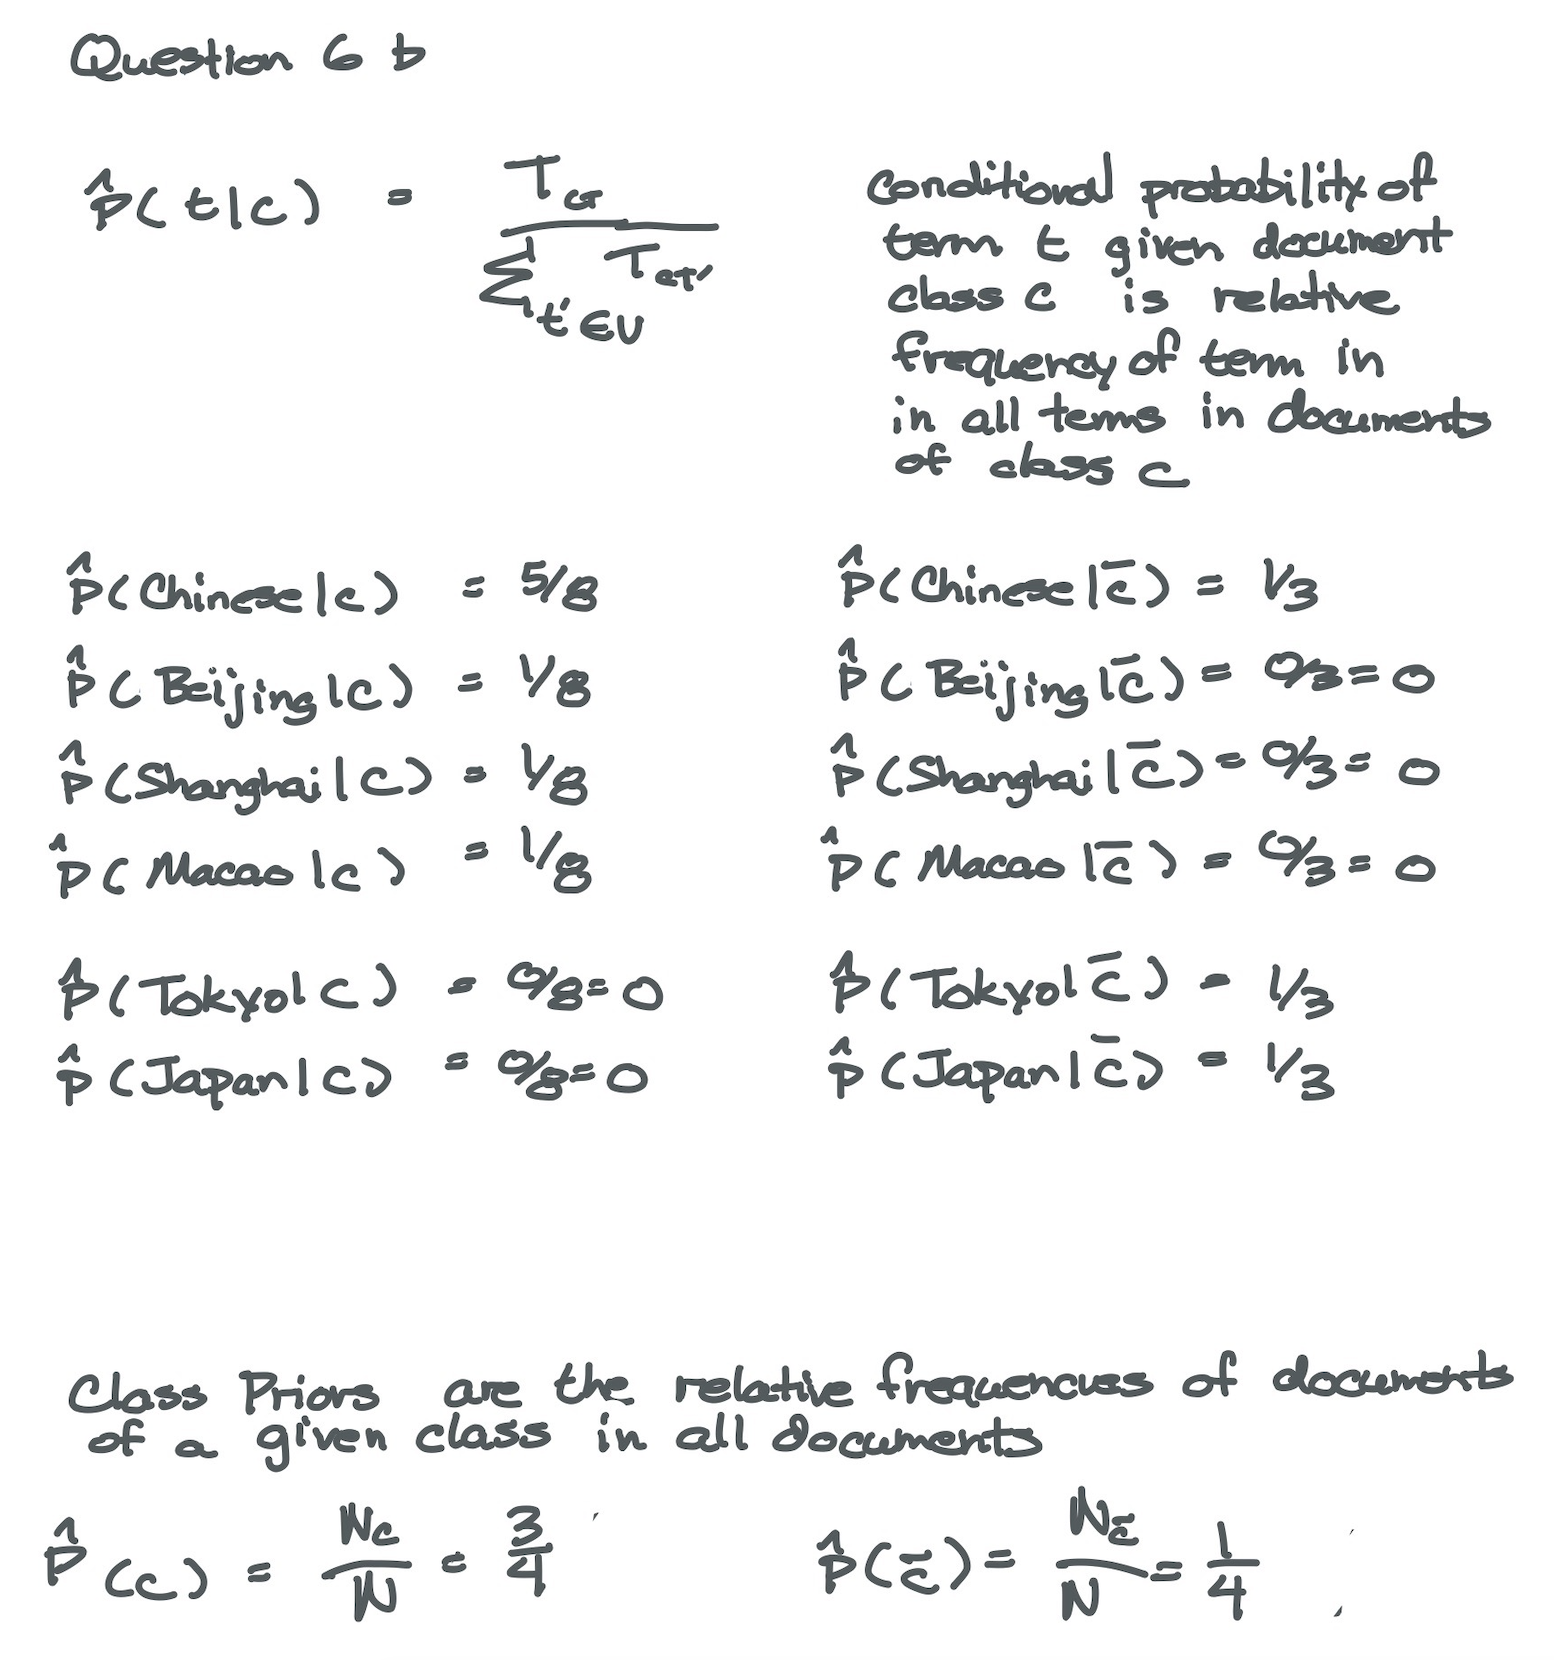

In [27]:
# part d/e - if you didn't write out your calcuations above, embed a picture of them here:
from IPython.display import Image
Image(filename="hand_calculations/HW2_Q6b.png")

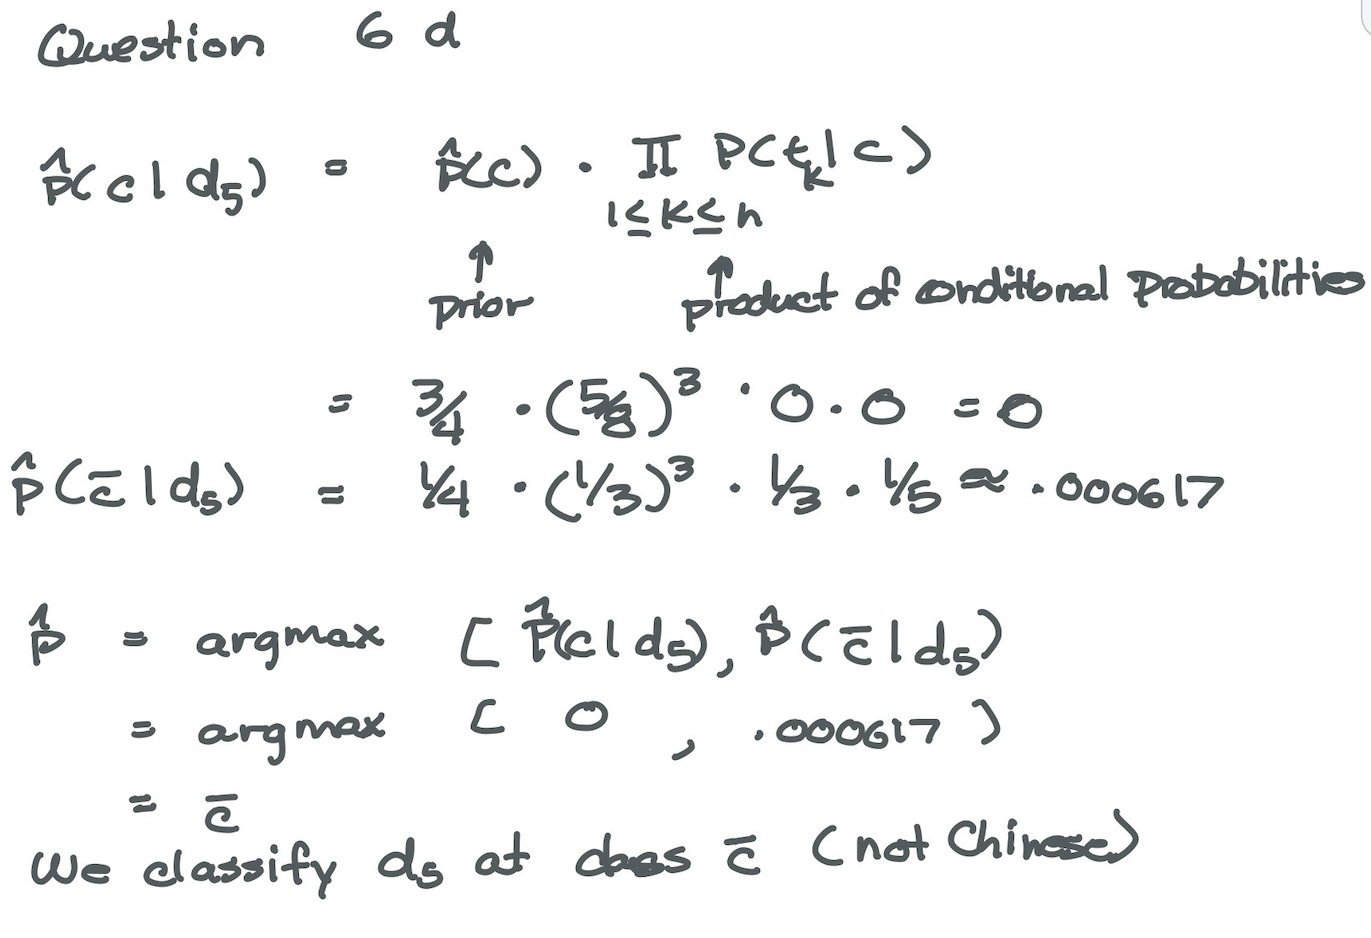

In [28]:
# part e - Image of hand calculations
from IPython.display import Image
Image(filename="hand_calculations/HW2_Q6d.png")

# Question 7: Naive Bayes Inference.
In the next two questions you'll write code to parallelize the Naive Bayes calculations that you performed above. We'll do this in two phases: one MapReduce job to perform training and a second MapReduce to perform inference. While in practice we'd need to train a model before we can use it to classify documents, for learning purposes we're going to develop our code in the opposite order. By first focusing on the pieces of information/format we need to perform the classification (inference) task you should find it easier to develop a solid implementation for training phase when you get to question 8 below. In both of these questions we'll continue to use the Chinese example corpus from the textbook to help us test our MapReduce code as we develop it. Below we've reproduced the corpus, test set and model in text format that matches the Enron data.

### Q7 Tasks:
* __a) short response:__ run the provided cells to create the example files and load them in to HDFS. Then take a closer look at __`NBmodel.txt`__. This text file represents a Naive Bayes model trained (with Laplace +1 smoothing) on the example corpus. What are the 'keys' and 'values' in this file? Which record means something slightly different than the rest? The value field of each record includes two numbers which will be helpful for debugging but which we don't actually need to perform inference -- what are they? [`HINT`: _This file represents the model from Example 13.1 in the textbook, if you're having trouble getting oriented try comparing our file to the numbers in that example._]


* __b) short response:__ When performing Naive Bayes in practice instead of multiplying the probabilities (as in equation 13.3) we add their logs (as in equation 13.4). Why do we choose to work with log probabilities? If we had an unsmoothed model, what potential error could arise from this transformation?


* __c) short response:__ Documents 6 and 8 in the test set include a word that did not appear in the training corpus (and as a result does not appear in the model). What should we do at inference time when we need a class conditional probability for this word?


* __d) short response:__ The goal of our MapReduce job is to stream over the test set and classify each document by peforming the calculation from equation 13.4. To do this we'll load the model file (which contains the probabilities for equation 13.4) into memory on the nodes where we do our mapping. This is called an in-memory join. Does loading a model 'state' like this depart from the functional programming principles? Explain why or why not. From a scability perspective when would this kind of memory use be justified? when would it be unwise?


* __e) code:__ Complete the code in __`NaiveBayes/classify_mapper.py`__. Read the docstring carefully to understand how this script should work and the format it should return. Run the provided unit tests to confirm that your script works as expected then write a Hadoop streaming job to classify the Chinese example test set. [`HINT 1:` _you shouldn't need a reducer for this one._ `HINT 2:` _Don't forget to add the model file to the_ `-files` _parameter in your Hadoop streaming job so that it gets shipped to the mapper nodes where it will be accessed by your script._]


* __f) short response:__ In our test example and in the Enron data set we have fairly short documents. Since these fit fine in memory on a mapper node we didn't need a reducer and could just do all of our calculations in the mapper. However with much longer documents (eg. books) we might want a higher level of parallelization -- for example we might want to process parts of a document on different nodes. In this hypothetical scenario how would our algorithm design change? What could the mappers still do? What key-value structure would they emit? What would the reducers have to do as a last step?

### Q7 Student Answers:
> __a)__ The key is the word and the value is array with the following elements:  element 1 the frequency of this word in 'Chinese' documents, element 2 is the word frequency in 'not Chinese' documents, element 3 is the liklihood of the word in a 'Chinese' document, element 4 is the liklihood of the word in a 'not Chinese' document.  The unusual record is the one with the key 'ClassPriors', which contains an array with the tally of 'Chinese' documents, tally of 'not Chinese' documents, the prior (document frequency) of 'Chinese' documents and the prior of 'not Chinese documents. We include the word and document frequencies for debugging purposes; the Naive Bayes algorithm only requires the word liklihoods and the class priors.

> __b)__ The products of the liklihoods will compute to such small numbers that we run the risk of floating point underflow.  To avoid this, we use the log of the liklihood, which allows us to add rather than multiply the values and avoid the risk of floating point underflow.  With a unsmoothed model, we run the risk of trying the calculate the liklihood for a word with 0 occurrences in a document of a given class.  In this case, we will calculate with a log(0), which is undefined, resulting in a runtime error.

> __c)__ At inference time, we have the problem of divide-by-zero when calculating the conditional probability for a unseen word.  So, we can either skip the word, or provide smoothing by giving these unseen words a small non-zero probability (for both classes), so that the posterior probabilities don't suddenly drop to zero.  In the first case, when we are adding the log of probabilities, we simply check if the word exists in the vocabulary; if not, it just uses log(1), which results in 0, essentially 'skipping' this unseen word.  In the second case, we would need the total word count of each class and the vocab size to perform smoothing, only for the unseen word.  The first case seems like a sensible approach given that the second approach is essentially assigning an very low probability to these unseen words, which shouldn't impact the classification.  

> __d)__ In-memory joining does not violate the functional programming paradigm of being "stateless" since the model of term and document frequencies is immutable. This technique will result in much faster predictions on our test documents since the model will be loaded into memory beforehand.  So training the model may be quite time-consuming, but once the model is training, running the predicuts should be fast. We won't incur the disk i/o and network traffic on our model.  This approach only makes sense if we can guarantee that the model can fit into memory; otherwise, we will need to devise an approach that limits the document and term frequencies to only those encountered in the test document.  

> __e)__ Complete the coding portion of this question before answering 'f'.

> __f)__ To support very large documents during inference, we would have to be able to split a document into smaller chunks, resulting in multiple mappers running in parallel. Then each mapper would emit the summation of log probabilities for each word; which would represent on a "subtotal" of the log of probabilities for the word.  The mapper would emit the document and word and the (partial) total log of the conditional probabilities, but not be responsible for the arg max to determine the higher conditional probability between the classes for the document.  Instead, this would move to the reducer.  Here the reducer would aggregate log probabilities for each word in a document, across all words in the document. Then for each document, the reducer would emit one record for each document, containing the document id and the argmax between the 2 class total log probabilities along with the predicted class.  The key/value structure emitted from the mapper would be a partition key, document, and word and the value would be the total (partial) log of probabilities for class0, total (paritial) log of probabilities for class1.  The reducer would emit a key of document id and a value containing the total log of probabilities for class0, class1, and then the predicted class for the document (based on the argmax).


Run these cells to create the example corpus and model.

In [29]:
%%writefile NaiveBayes/chineseTrain.txt
D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese

Overwriting NaiveBayes/chineseTrain.txt


In [30]:
%%writefile NaiveBayes/chineseTest.txt
D5	1		Chinese Chinese Chinese Tokyo Japan
D6	1		Beijing Shanghai Trade
D7	0		Japan Macao Tokyo
D8	0		Tokyo Japan Trade

Overwriting NaiveBayes/chineseTest.txt


In [31]:
%%writefile NBmodel.txt
beijing	0.0,1.0,0.111111111111,0.142857142857
chinese	1.0,5.0,0.222222222222,0.428571428571
tokyo	1.0,0.0,0.222222222222,0.0714285714286
shanghai	0.0,1.0,0.111111111111,0.142857142857
ClassPriors	1.0,3.0,0.25,0.75
japan	1.0,0.0,0.222222222222,0.0714285714286
macao	0.0,1.0,0.111111111111,0.142857142857

Overwriting NBmodel.txt


In [32]:
# load the data files into HDFS
!hdfs dfs -rm NaiveBayes/chineseTrain.txt
!hdfs dfs -rm NaiveBayes/chineseText.txt
!hdfs dfs -copyFromLocal NaiveBayes/chineseTrain.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal NaiveBayes/chineseTest.txt {HDFS_DIR}

rm: `NaiveBayes/chineseTrain.txt': No such file or directory
rm: `NaiveBayes/chineseText.txt': No such file or directory


Your work for `part e` starts here:

In [33]:
# part e - do your work in NaiveBayes/classify_mapper.py first, then run this cell.
!chmod a+x NaiveBayes/classify_mapper.py

In [34]:
# part e - unit test NaiveBayes/classify_mapper.py (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


In [35]:
# part e - clear the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/chinese-output

rm: `/user/root/HW2//chinese-output': No such file or directory


In [36]:
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/chineseTest.txt \
  -output {HDFS_DIR}/chinese-output \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1306700272399976230.jar tmpDir=null
20/01/28 21:40:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:40:23 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:40:24 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:40:24 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:40:25 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0011
20/01/28 21:40:25 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0011
20/01/28 21:40:25 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0011/
20/01/28 21:40:25 INFO mapreduce.Job: Running job: job_1580239463204_0011
20/01/28 21:40:35 INFO mapreduce.Job: Job job_1580239463204_0011 running in uber mode : false
20/01/28 21:40:35 INFO mapreduce.Job:  map 0% reduce 0%
20/01

In [37]:
# part e - retrieve test set results from HDFS (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/chinese-output/part-000* > NaiveBayes/chineseResults.txt

In [38]:
# part e - take a look (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseResults.txt | column -t

d5  1  -8.90668134500626   -8.10769031284611   1
d6  1  -5.780743515794329  -4.179502370564408  1
d7  0  -6.591673732011658  -7.511706880737811  0
d8  0  -4.394449154674438  -5.565796731681498  0


<table>
<th> Expected output for the test set:</th>
<tr align=Left><td><pre>
d5	1	-8.90668134	-8.10769031	1
d6	1	-5.78074351	-4.17950237	1
d7	0	-6.59167373	-7.51170688	0
d8	0	-4.39444915	-5.56579673	0
</pre></td><tr>
</table>

# Question 8: Naive Bayes Training.
In Question 7 we used a model that we had trained by hand. Next we'll develop the code to do that same training in parallel, making it suitable for use with larger corpora (like the Enron emails). The end result of the MapReduce job you write in this question should be a model text file that looks just like the example (`NBmodel.txt`) that we created by hand above.

To refresh your memory about the training process take a look at  `6a` and `6b` where you described the pieces of information you'll need to collect in order to encode a Multinomial Naive Bayes model. We now want to retrieve those pieces of information while streaming over a corpus. The bulk of the task will be very similar to the word counting excercises you've already done but you may want to consider a slightly different key-value record structure to efficiently tally counts for each class. 

The most challenging (interesting?) design question will be how to retrieve the totals (# of documents and # of words in documents for each class). Of course, counting these numbers is easy. The hard part is the timing: you'll need to make sure you have the counts totalled up _before_ you start estimating the class conditional probabilities for each word. It would be best (i.e. most scalable) if we could find a way to do this tallying without storing the whole vocabulary in memory... Use an appropriate MapReduce design pattern to implement this efficiently! 


### Q8 Tasks:
* __a) make a plan:__  Fill in the docstrings for __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ to appropriately reflect the format that each script will input/output. [`HINT:` _the input files_ (`enronemail_1h.txt` & `chineseTrain.txt`) _have a prespecified format and your output file should match_ `NBmodel.txt` _so you really only have to decide on an internal format for Hadoop_].


* __b) implement it:__ Complete the code in __`NaiveBayes/train_mapper.py`__ and __`NaiveBayes/train_reducer.py`__ so that together they train a Multinomial Naive Bayes model __with no smoothing__. Make sure your end result is formatted correctly (see note above). Test your scripts independently and together (using `chineseTrain.txt` or test input of your own devising). When you are satisfied with your Python code design and run a Hadoop streaming command to run your job in parallel on the __chineseTrain.txt__. Confirm that your trained model matches your hand calculations from Question 5.


* __c) short response:__ We saw in Question 6 that adding Laplace +1 smoothing makes our classifications less sensitve to rare words. However implementing this technique requires access to one additional piece of information that we had not previously used in our Naive Bayes training. What is that extra piece of information? [`HINT:` see equation 13.7 in Manning, Raghavan and Schutze].


* __d) short response:__ There are a couple of approaches that we could take to handle the extra piece of information you identified in `c`: 1) if we knew this extra information beforehand, we could provide it to our reducer as a configurable parameter for the vocab size dynamically (_where would we get it in the first place?_). Or 2) we could compute it in the reducer without storing any bulky information in memory but then we'd need some postprocessing or a second MapReduce job to complete the calculation (_why?_). Breifly explain what is non-ideal about each of these options. 


* __e) code + short response:__ Choose one of the 2 options above. State your choice & reasoning in the space below then use that strategy to complete the code in __`NaiveBayes/train_reducer_smooth.py`__. Test this alternate reducer then write and run a Hadoop streaming job to train an MNB model with smoothing on the Chinese example. Your results should match the model that we provided for you above (and the calculations in the textbook example). __IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. 

    - [`HINT:` You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)] 

    - [`HINT:` Don't start from scratch with this one -- you can just copy over your reducer code from part `b` and make the needed modifications]. 



__IMPORTANT NOTE:__ For full credit on this question, your code must work with multiple reducers. [`HINT:`_You will need to implement custom partitioning - [Total Order Sort Notebook](https://github.com/UCB-w261/main/tree/master/HelpfulResources/TotalSortGuide/_total-sort-guide-spark2.01-JAN27-2017.ipynb)]


### Q8 Student Answers:
> __c)__ Laplace +1 smoothing will require the number of words in the vocabulary.  The vocabulary size (number of unique words in training corpus) will be added to to the total number of word occurrences in the class in the denominator. 

> __d)__  With the first option, we need some way of calculating the vocabulary size before our MapReduce job.  So this would either have to be an estimate or another preprocessing step that counts the total number of words.  If it is an estimate, it could be off from the actual vocabulary size; if it is calculated in a preprocessing step, we run the risk of the vocab size being out-of-date with our current training data.  If we use the second option, introducing a MapReduce job to calculate the vocab size and then using it as input to the second MapReduce job that performs the calculation, we are assured that this is the true vocabulary size, but this could be a fairly expensive operation since every ocurrence of a word to be emitted from the mapper, resulting in large network I/O and an expensive shuffle phase.

> __e)__  I favor the approach of having an up-to-date vocabulary size, so I implemented the second option.  The first MapReduce job will calculate the vocabulary size, reusing the mapper and reducer created in EnronEDA.  This will become an input file to the second MapReduce job that calculates the conditional probabilities with Laplace+1 smoothing. 


In [39]:
# part a - do your work in train_mapper.py and train_reducer.py then RUN THIS CELL AS IS
!chmod a+x NaiveBayes/train_mapper.py
!chmod a+x NaiveBayes/train_reducer.py

#todo remove
!chmod a+x NaiveBayes/debug_reducer.py

!echo "=========== MAPPER DOCSTRING ============"
!head -n 8 NaiveBayes/train_mapper.py | tail -n 6
!echo "=========== REDUCER DOCSTRING ============"
!head -n 8 NaiveBayes/train_reducer.py | tail -n 6

chmod: cannot access `NaiveBayes/debug_reducer.py': No such file or directory
=========== MAPPER DOCSTRING ============
Mapper reads in text documents and emits word counts by class.
INPUT:                                                    
    DocID \t true_class \t subject \t body                
OUTPUT:                                                   
    partitionKey \t word \t class0_partialCount,class1_partialCount       
    
=========== REDUCER DOCSTRING ============
Reducer aggregates word counts by class and emits frequencies.

INPUT:                                               
    partitionKey \t word \t class0_partialCount,class1_partialCount       
OUTPUT:
    word \t class0_count,class1_count,class0_frequency,class1_frequency


__`part b starts here`:__ MNB _without_ Smoothing (training on Chinese Example Corpus).

In [40]:
# part b - write a unit test for your mapper here
import os
os.environ["mapreduce_job_reduces"] = "1"
!echo -e "d1	1	title Dog cat	bodY dog kitten\nd2	0	title foo bar	body dog" | NaiveBayes/train_mapper.py

A	title	0,1
A	dog	0,1
A	cat	0,1
A	body	0,1
A	dog	0,1
A	kitten	0,1
A	title	1,0
A	foo	1,0
A	bar	1,0
A	body	1,0
A	dog	1,0
A	**total_word_count	5,6
A	**total_doc_count	1,1


In [41]:
# part b - write a unit test for your reducer here
!echo -e "A	**total_word_count	0,50\nA	**total_word_count	5,7\nA	**total_doc_count	1,4\nA	china	5,0\nA	china	0,1\nA	dog	0,2\nA	dog	0,4\nA	cat	0,50" | NaiveBayes/train_reducer.py

china	5,1,1.0,0.017543859649122806
dog	0,6,0,0.10526315789473684
cat	0,50,0,0.8771929824561403
ClassPriors	1.0,4.0,0.2,0.8


In [42]:
# part b - write a systems test for your mapper + reducer together here
os.environ["mapreduce_job_reduces"] = "1"
!echo -e "d1	1	title Dog cat	bodY dog kitten\nd2	0	title foo bar	body dog" \
   | NaiveBayes/train_mapper.py \
   | sort -k1,1 \
   | NaiveBayes/train_reducer.py

bar	1,0,0.2,0
body	1,1,0.2,0.16666666666666666
cat	0,1,0,0.16666666666666666
dog	1,2,0.2,0.3333333333333333
foo	1,0,0.2,0
kitten	0,1,0,0.16666666666666666
title	1,1,0.2,0.16666666666666666
ClassPriors	1.0,1.0,0.5,0


In [43]:
# part b - clear (and name) an output directory in HDFS for your unsmoothed chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-output

rm: `/user/root/HW2//chinese-train-output': No such file or directory


In [44]:
# part b - write your hadoop streaming job

# Calculate the word conditional frequencies in this MapReduce job.
# The mapper will output a key/value pair for each word encountered 
# (either 0 or 1 for class0, then 0 or 1 for class1) and
# emit the total word count for each class and total doc count for each class.
# We will use multiple reducers, so we must use a custom partition key so that
# the multiple total records (from each split) will be copied to every partition.
# The reducer will then calculate the conditional probabilities for each word
# (unsmoothed)

!hadoop jar {JAR_FILE} \
  -D mapreduce.job.reduces=3 \
  -D stream.num.map.output.key.fields=1 \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py  \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-output \
  -cmdenv PATH={PATH}

packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6567148913361803325.jar tmpDir=null
20/01/28 21:41:19 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:41:19 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:41:20 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:41:20 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:41:21 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0012
20/01/28 21:41:21 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0012
20/01/28 21:41:21 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0012/
20/01/28 21:41:21 INFO mapreduce.Job: Running job: job_1580239463204_0012
20/01/28 21:41:32 INFO mapreduce.Job: Job job_1580239463204_0012 running in uber mode : false
20/01/28 21:41:32 INFO mapreduce.Job:  map 0% reduce 0%
20/01

In [45]:
# part b - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-output/part-000* > NaiveBayes/chinese_nb_model.txt

In [46]:
# part b - print your model so that we can confirm that it matches expected results
!cat NaiveBayes/chinese_nb_model.txt

shanghai	0,1,0,0.125
beijing	0,1,0,0.125
tokyo	1,0,0.3333333333333333,0
chinese	1,5,0.3333333333333333,0.625
japan	1,0,0.3333333333333333,0
macao	0,1,0,0.125
ClassPriors	1.0,3.0,0.25,0.75


In [47]:
!cat NaiveBayes/chineseTrain.txt

D1	1		Chinese Beijing Chinese
D2	1		Chinese Chinese Shanghai
D3	1		Chinese Macao
D4	0		Tokyo Japan Chinese


__`part e starts here`:__ MNB _with_ Smoothing (training on Chinese Example Corpus).

In [48]:
# part e - write a unit test for your NEW reducer here
!chmod a+x NaiveBayes/train_reducer_smooth.py

!echo -e "** Unit test reducer (smoothed) **"

!echo -e "3" > vocab_size.txt
!echo -e "A	**total_word_count	0,50\nA	**total_word_count	5,7\nA	**total_doc_count	1,4\nA	china	5,0\nA	china	0,1\nA	dog	0,2\nA	dog	0,4\nA	cat	0,50" | NaiveBayes/train_reducer_smooth.py

!echo -e "\n** Unit test mapper + reducer (smoothed) **"

import os
os.environ["mapreduce_job_reduces"] = "1"
!echo -e "7" > vocab_size.txt
!echo -e "d1	1	title Dog cat	bodY dog kitten\nd2	0	title foo bar	body dog" \
   | NaiveBayes/train_mapper.py \
   | sort -k1,1 \
   | NaiveBayes/train_reducer_smooth.py

** Unit test reducer (smoothed) **
china	5.0,1.0,0.75,0.03333333333333333
dog	0.0,6.0,0.125,0.11666666666666667
cat	0.0,50.0,0.125,0.85
ClassPriors	1.0,4.0,0.2,0.8

** Unit test mapper + reducer (smoothed) **
bar	1.0,0.0,0.16666666666666666,0.07692307692307693
body	1.0,1.0,0.16666666666666666,0.15384615384615385
cat	0.0,1.0,0.08333333333333333,0.15384615384615385
dog	1.0,2.0,0.16666666666666666,0.23076923076923078
foo	1.0,0.0,0.16666666666666666,0.07692307692307693
kitten	0.0,1.0,0.08333333333333333,0.15384615384615385
title	1.0,1.0,0.16666666666666666,0.15384615384615385
ClassPriors	1.0,1.0,0.5,0.5


In [49]:
# part e - clear (and name) an output directory in HDFS for your SMOOTHED chinese NB model
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-smooth-output

rm: `/user/root/HW2//chinese-train-smooth-output': No such file or directory


In [50]:
#
# part e - Generate NB model for chinese training corpus using Laplace +1 smoothing
#

#
# First, calculate the vocabulary size for the Chinese train corpus
#

# remove the hdfs output
!hdfs dfs -rm -r {HDFS_DIR}/chinese_unique_words/

# Run a MapReduce job that outputs 2 lines (one for class0, another for class1) for each 
# unique word
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese_unique_words \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}

# Concatenate the hdfs output to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese_unique_words/part-000* > NaiveBayes/unique_words.txt


# Run unique on the word column to get a count of unique words (vocab size). Save this to a local
# file that will be input to our MapReduce job that will calculate word conditional probabilities
# using Laplace +1 smoothing (which requires vocab size)
!cat NaiveBayes/unique_words.txt | cut -f1 | uniq | wc -l > NaiveBayes/vocab_size.txt
!cat NaiveBayes/vocab_size.txt


#
#
# Second, calculate the word conditional frequencies in this second MapReduce job.
# The mapper will output a key/value pair for each word encountered and
# emit the total word count for each class and total doc count for each class.
# We will use multiple reducers, so we must use a custom partition key so that
# the multiple total records (from each split) will be copied to every partition.
# We also send in the vocab size as local file input so that the reducer
# can calculate conditional probabilities for each word with Laplace +1 smoothing.
#

# Remove the hdfs output for the MapReduce job
!hdfs dfs -rm -r {HDFS_DIR}/chinese-train-smooth-output

# Now that we have the vocab size, run a MapReduce job to calculate the conditional probabilities and class priors.
!hadoop jar {JAR_FILE} \
  -D mapreduce.job.reduces=3 \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2" \
  -files  NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py,NaiveBayes/vocab_size.txt  \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/chineseTrain.txt \
  -output {HDFS_DIR}/chinese-train-smooth-output \
  -cmdenv PATH={PATH}

rm: `/user/root/HW2//chinese_unique_words/': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7572737007427894534.jar tmpDir=null
20/01/28 21:42:29 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:42:30 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:42:31 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:42:31 WARN hdfs.DFSClient: Caught exception 
java.lang.InterruptedException
	at java.lang.Object.wait(Native Method)
	at java.lang.Thread.join(Thread.java:1252)
	at java.lang.Thread.join(Thread.java:1326)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.closeResponder(DFSOutputStream.java:969)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.endBlock(DFSOutputStream.java:707)
	at org.apache.hadoop.hdfs.DFSOutputStream$DataStreamer.run(DFSOutputStream.java:896)
20/01/28 21:42:31 INFO mapreduce.JobSubmitter: number

In [51]:
# part e - extract your results (i.e. model) to a local file
!hdfs dfs -cat {HDFS_DIR}/chinese-train-smooth-output/part-000* > NaiveBayes/chinese_smooth_nb_model.txt
!cat  NaiveBayes/chinese_smooth_nb_model.txt

shanghai	0.0,1.0,0.1111111111111111,0.14285714285714285
beijing	0.0,1.0,0.1111111111111111,0.14285714285714285
tokyo	1.0,0.0,0.2222222222222222,0.07142857142857142
chinese	1.0,5.0,0.2222222222222222,0.42857142857142855
japan	1.0,0.0,0.2222222222222222,0.07142857142857142
macao	0.0,1.0,0.1111111111111111,0.14285714285714285
ClassPriors	1.0,3.0,0.25,0.75


# Question 9: Enron Ham/Spam NB Classifier & Results.

Fantastic work. We're finally ready to perform Spam Classification on the Enron Corpus. In this question you'll run the analysis you've developed, report its performance.

### Q9 Tasks:
* __a) train/test split:__ Run the provided code to split our Enron file into a training set and testing set then load them into HDFS. [`NOTE:` _Make sure you re calculate the vocab size for just the training set!_]

* __b) train 2 models:__ Write Hadoop Streaming jobs to train MNB Models on the training set with and without smoothing. Save your models to local files at __`NaiveBayes/Unsmoothed/NBmodel.txt`__ and __`NaiveBayes/Smoothed/NBmodel.txt`__. [`NOTE:` _This naming is important because we wrote our classification task so that it expects a file of that name... if this inelegance frustrates you there is an alternative that would involve a few adjustments to your code [read more about it here](http://www.tnoda.com/blog/2013-11-23)._] Finally run the checks that we provide to confirm that your results are correct.


* __c) code:__ Recall that we designed our classification job with just a mapper. An efficient way to report the performance of our models would be to simply add a reducer phase to this job and compute precision and recall right there. Complete the code in __`NaiveBayes/evaluation_reducer.py`__ and then write Hadoop jobs to evaluate your two models on the test set. Report their performance side by side. [`NOTE:` if you need a refresher on precision, recall and F1-score [Wikipedia](https://en.wikipedia.org/wiki/F1_score) is a good resource.]


* __d) short response:__ Compare the performance of your two models. What do you notice about the unsmoothed model's predictions? Can you guess why this is happening? Which evaluation measure do you think is most relevant in our use case? [`NOTE:` _Feel free to answer using your common sense but if you want more information on evaluating the classification task checkout_ [this blogpost](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/
) or [this paper](http://www.flinders.edu.au/science_engineering/fms/School-CSEM/publications/tech_reps-research_artfcts/TRRA_2007.pdf
)]



### Q9 Student Answers:
> __d)__ The unsmoothed model has higher precision, but the smoothed model performs better overall, with higher recall, accuracy and F-score.  The unsmoothed model has more true negatives and more false negatives, to it is bias toward predicting !spam.  This may be due to the penalty of unseen !spam words in our training document or the tendency for not-spam (ham) documents to be longer than spam documents, increasing the chance of encountering unseen words at inference time.  

> Precision tells us "out of all documents predicted as spam, what fraction is correct?"  So with the unsmoothed model we have 1 true position and 1 false positive, indicating that very few documents were predicted as spam.  With the smoothed model, we see more true positives, as well as more false positives.  This will bring down the precision, but we see much better recall.  Recall tells us "out of all of the spam documents, how many did the classifier pick?"  So with the smoothed model, we see that it was able to detect the spam documents. For classifying spam/ham emails, I think we need a good balance between precision and recall, but of the two, it is important to be confident that the prediction is true (true positives), so I would evaluate precision first. (We don't want 'real', e.g. !spam, emails ending up in the junk folder.)  But since precision doesn't give us a full picture of the 'missed' positives, it can't be considered in isolation.  That is why the F-score would be a better overall metric.

__Test/Train split__

In [52]:
# part a - test/train split (RUN THIS CELL AS IS)
!head -n 80 data/enronemail_1h.txt > data/enron_train.txt
!tail -n 20 data/enronemail_1h.txt > data/enron_test.txt
!hdfs dfs -copyFromLocal data/enron_train.txt {HDFS_DIR}
!hdfs dfs -copyFromLocal data/enron_test.txt {HDFS_DIR}

__Training__ (Enron MNB Model _without smoothing_ )

In [53]:
# part b -  Unsmoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron-model

# hadoop command

# Calculate the word conditional frequencies in this MapReduce job.
# The mapper will output a key/value pair for each word encountered 
# (either 0 or 1 for class0, then 0 or 1 for class1) and
# emit the total word count for each class and total doc count for each class.
# We will use multiple reducers, so we must use a custom partition key so that
# the multiple total records (from each split) will be copied to every partition.
# The reducer will then calculate the conditional probabilities for each word
# (unsmoothed)
!hadoop jar {JAR_FILE} \
  -D mapreduce.job.reduces=3 \
  -D stream.num.map.output.key.fields=1 \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2" \
  -files NaiveBayes/train_mapper.py,NaiveBayes/train_reducer.py  \
  -mapper train_mapper.py \
  -reducer train_reducer.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron-model \
  -cmdenv PATH={PATH}


# save the model locally
!mkdir NaiveBayes/Unsmoothed
!hdfs dfs -cat {HDFS_DIR}/enron-model/part-000* > NaiveBayes/Unsmoothed/NBmodel.txt

rm: `/user/root/HW2//enron-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob1810759967609187240.jar tmpDir=null
20/01/28 21:44:38 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:44:39 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:44:40 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:44:40 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:44:40 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0015
20/01/28 21:44:41 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0015
20/01/28 21:44:41 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0015/
20/01/28 21:44:41 INFO mapreduce.Job: Running job: job_1580239463204_0015
20/01/28 21:44:51 INFO mapreduce.Job: Job job_1580239463204_0015 running in uber mode : false


In [54]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000172547666293,0.000296823983378

assistance	2,4,0.0001725476662928134,0.00029682398337785694


In [55]:
# part b - check your UNSMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Unsmoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,8.62738331464e-05,0.00163253190858

money	1,22,8.62738331464067e-05,0.001632531908578213


__Training__ (Enron MNB Model _with Laplace +1 smoothing_ )

In [56]:
# part b -  Smoothed model (FILL IN THE MISSING CODE BELOW)

# clear the output directory
!hdfs dfs -rm -r {HDFS_DIR}/enron_unique_words
!hdfs dfs -rm -r {HDFS_DIR}/smooth-model


# Run a MapReduce job that outputs 2 lines (one for class0, another for class1) for each 
# unique word
!hadoop jar {JAR_FILE} \
  -files EnronEDA/reducer.py,EnronEDA/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/enron_unique_words \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}


# This reports the number of unique words for the enron training set (vocab size)
!hdfs dfs -cat {HDFS_DIR}/enron_unique_words/part-000* > EnronEDA/train_unique_words.txt
!cat EnronEDA/train_unique_words.txt| cut -f1 | uniq | wc -l > EnronEDA/vocab_size.txt
!cat EnronEDA/vocab_size.txt


# Now that we have the vocab size, run a MapReduce job to calculate the conditional probabilities and class priors.
!hadoop jar {JAR_FILE} \
  -D mapreduce.job.reduces=3 \
  -D stream.num.map.output.key.fields=2 \
  -D mapreduce.partition.keypartitioner.options=-k1,1 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2" \
  -files  NaiveBayes/train_mapper.py,NaiveBayes/train_reducer_smooth.py,EnronEDA/vocab_size.txt  \
  -mapper train_mapper.py \
  -reducer train_reducer_smooth.py \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/enron_train.txt \
  -output {HDFS_DIR}/smooth-model \
  -cmdenv PATH={PATH}

# save the model locally
!mkdir NaiveBayes/Smoothed
!rm NaiveBayes/Smoothed/NBmodel.txt
!hdfs dfs -cat {HDFS_DIR}/smooth-model/part-000* > NaiveBayes/Smoothed/NBmodel.txt

rm: `/user/root/HW2//enron_unique_words': No such file or directory
rm: `/user/root/HW2//smooth-model': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob119286966277354954.jar tmpDir=null
20/01/28 21:45:49 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:45:49 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:45:51 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:45:51 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:45:51 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0016
20/01/28 21:45:51 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0016
20/01/28 21:45:51 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0016/
20/01/28 21:45:51 INFO mapreduce.Job: Running job: job_1580239463204_0016
20/01/28 21:46:01 INFO map

In [57]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep assistance NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: assistance	2,4,0.000185804533631,0.000277300205202

assistance	2.0,4.0,0.0001858045336306206,0.00027730020520215184


In [58]:
# part b - check your SMOOTHED model results (RUN THIS CELL AS IS)
!grep money NaiveBayes/Smoothed/NBmodel.txt
# EXPECTED OUTPUT: money	1,22,0.000123869689087,0.00127558094393

money	1.0,22.0,0.0001238696890870804,0.0012755809439298986


__Evaluation__

In [59]:
# part c - write your code in NaiveBayes/evaluation_reducer.py then RUN THIS
!chmod a+x NaiveBayes/evaluation_reducer.py

In [60]:
# part c - unit test your evaluation job on the chinese model (RUN THIS CELL AS IS)
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py 
!cat NaiveBayes/chineseTest.txt | NaiveBayes/classify_mapper.py | NaiveBayes/evaluation_reducer.py

d5	1	-8.90668134500626	-8.10769031284611	1
d6	1	-5.780743515794329	-4.179502370564408	1
d7	0	-6.591673732011658	-7.511706880737811	0
d8	0	-4.394449154674438	-5.565796731681498	0
d5	1	-8.90668134500626	-8.10769031284611	 True
d6	1	-5.780743515794329	-4.179502370564408	 True
d7	0	-6.591673732011658	-7.511706880737811	 True
d8	0	-4.394449154674438	-5.565796731681498	 True
# Documents	4.0
True Positives	2.0
True Negatives	2.0
False Positives	0.0
False Negatives	0.0
Accuracy	1.0
Precision	1.0
Recall	1.0
F-score	1.0


In [61]:
# part c - Evaluate the UNSMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-enron

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Unsmoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-enron \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/evaluate-enron/part-000* > NaiveBayes/Unsmoothed/results.txt

rm: `/user/root/HW2//evaluate-enron': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob8231993046073860690.jar tmpDir=null
20/01/28 21:47:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:47:53 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:47:54 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:47:54 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:47:54 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0018
20/01/28 21:47:55 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0018
20/01/28 21:47:55 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0018/
20/01/28 21:47:55 INFO mapreduce.Job: Running job: job_1580239463204_0018
20/01/28 21:48:05 INFO mapreduce.Job: Job job_1580239463204_0018 running in uber mode : fal

In [62]:
# part c - Evaluate the SMOOTHED Model Here (FILL IN THE MISSING CODE)

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/evaluate-smoothed

# hadoop job
!hadoop jar {JAR_FILE} \
  -files NaiveBayes/classify_mapper.py,NaiveBayes/evaluation_reducer.py,NaiveBayes/Smoothed/NBmodel.txt \
  -mapper classify_mapper.py \
  -reducer evaluation_reducer.py \
  -input {HDFS_DIR}/enron_test.txt \
  -output {HDFS_DIR}/evaluate-smoothed \
  -numReduceTasks 1 \
  -cmdenv PATH={PATH}


# retrieve results locally
!hdfs dfs -cat {HDFS_DIR}/evaluate-smoothed/part-000* > NaiveBayes/Smoothed/results.txt


rm: `/user/root/HW2//evaluate-smoothed': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob6809954507913542679.jar tmpDir=null
20/01/28 21:48:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:48:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:48:41 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:48:41 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:48:42 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0019
20/01/28 21:48:42 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0019
20/01/28 21:48:42 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0019/
20/01/28 21:48:42 INFO mapreduce.Job: Running job: job_1580239463204_0019
20/01/28 21:48:52 INFO mapreduce.Job: Job job_1580239463204_0019 running in uber mode : 

In [63]:
# part c - display results 
# NOTE: feel free to modify the tail commands to match the format of your results file
print('=========== UNSMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Unsmoothed/results.txt
print('=========== SMOOTHED MODEL ============')
!tail -n 9 NaiveBayes/Smoothed/results.txt

=========== UNSMOOTHED MODEL ============
# Documents	20.0
True Positives	1.0
True Negatives	9.0
False Positives	0.0
False Negatives	10.0
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-score	0.1667
=========== SMOOTHED MODEL ============
# Documents	20.0
True Positives	11.0
True Negatives	6.0
False Positives	3.0
False Negatives	0.0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-score	0.88


__`EXPECTED RESULTS:`__ 
<table>
<th>Unsmoothed Model</th>
<th>Smoothed Model</th>
<tr>
<td><pre>
# Documents:	20
True Positives:	1
True Negatives:	9
False Positives:	0
False Negatives:	10
Accuracy	0.5
Precision	1.0
Recall	0.0909
F-Score	0.1666
</pre></td>
<td><pre>
# Documents:	20
True Positives:	11
True Negatives:	6
False Positives:	3
False Negatives:	0
Accuracy	0.85
Precision	0.7857
Recall	1.0
F-Score	0.88
</pre></td>
</tr>
</table>

__`NOTE:`__ _Don't be too disappointed if these seem low to you. We've trained and tested on a very very small corpus... bigger datasets coming soon!_

# Question 10: Custom Partitioning and Secondary Sort

Now that we have our model, we can analyse the results and think about future improvements.

### Q10 Tasks:

* __a) code + short response:__ Let's look at the top ten words with the highest conditional probability in `Spam` and in `Ham`. We'll do this by writing a Hadoop job that sorts the model file (`NaiveBayes/Smoothed/NBmodel.py`). Normally we'd have to run two jobs -- one that sorts on $P(word|ham)$ and another that sorts on $P(word|spam)$. However if we slighly modify the data format in the model file then we can get the top words in each class with just one job. We've written a mapper that will do just this for you. Read through __`NaiveBayes/model_sort_mapper.py`__ and then briefly explain how this mapper will allow us to partition and sort our model file. Write a Hadoop job that uses our mapper and `/bin/cat` for a reducer to partition and sort. Print out the top 10 words in each class (where 'top' == highest conditional probability).[`HINT:` _this should remind you a lot of what we did in Question 6._]


* __b) short response:__ What do you notice about the 'top words' we printed in `a`? How would increasing the smoothing parameter 'k' affect the probabilities for the top words that you identified for 'a'. How would they affect the probabilities of words that occur much more in one class than another? In summary, how does the smoothing parameter 'k' affect the bias and the variance of our model. [`NOTE:` _you do not need to code anything for this task, but if you are struggling with it you could try changing 'k' and see what happens to the test set. We don't recommend doing this exploration with the Enron data because it will be harder to see the impact with such a big vocabulary_]

### Q10 Student Answers:
> __a)__ __`NaiveBayes/model_sort_mapper.py`__ appends 2 more fields to each records:  the class that has the max conditional probability and the max conditional probability itself.  The 'class' of the max conditional probability will allow use to custom partition so that all records with 'ham' having the max conditional probability will go to one partition; and all records with 'spam' having the max conditional probability routed to another partition.  The other new field, the max conditional probability itself, will be the key by which we sort the records (in descending order) within the partition so that those words with the highest probability will appear first.

> __b)__ The top words, that is those with the highest conditional probabilities for both 'ham' and 'spam', are common words and have low discriminative power.  The conditional probabilities between one class and another are quite close.  The smoothing parameter adjusts the probability by adding $\frac{k}{\left | V \right |+k}$  to all conditional probabilities.  This will insure that rare (but not impossible) events don't have zero probabilities.  As we increase the smoothing parameter (k),this smoothing is applied across all of the words in the the training set, so the conditional probabilties of these common words will increase as well. As the smoothing parameter continues to increase, the conditional proabilities will be dominated by the smoothing (instead of the evidence), moving all conditional probabilities closer to a uniform distribution.

> How would they affect the probabilities of words that occur much more in one class than another?  As we increase the smoothing parameter, we would see less of a difference between the conditional probability of the word with strong evidence in one class vs the other class.  Essentially, the evidence for that word appearing in this class will be over-influenced by the smoothing factor.

> When we increase alpha of smoothing, this would lower the variance of our model (less fluctuations as we encounter different training data sets), but increase the bias, resulting in a model that doesn't accurately reflect the true liklihoods of these words occurring given a class.

In [64]:
# part a - write your Hadoop job here (sort smoothed model on P(word|class))

# put the smoothed model on HDFS
!hdfs dfs -copyFromLocal NaiveBayes/Smoothed/NBmodel.txt {HDFS_DIR}/smoothed_NBmodel.txt

# clear output directory
!hdfs dfs -rm -r {HDFS_DIR}/smoothed-model-cond-prob

# hadoop job
# part e - write your Hadooop streaming job here
!hadoop jar {JAR_FILE} \
  -D mapreduce.partition.keypartitioner.options=-k3,3 \
  -D stream.num.map.output.key.fields=1 \
  -D stream.map.output.field.separator="\t" \
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
  -D mapreduce.partition.keycomparator.options="-k4,4nr" \
  -files NaiveBayes/model_sort_mapper.py \
  -mapper model_sort_mapper.py \
  -reducer /bin/cat \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
  -input {HDFS_DIR}/smoothed_NBmodel.txt \
  -output {HDFS_DIR}/smoothed-model-cond-prob \
  -numReduceTasks 2 \
  -cmdenv PATH={PATH}
    


rm: `/user/root/HW2//smoothed-model-cond-prob': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob8962787225187402484.jar tmpDir=null
20/01/28 21:49:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:49:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/01/28 21:49:34 INFO mapred.FileInputFormat: Total input paths to process : 1
20/01/28 21:49:34 INFO mapreduce.JobSubmitter: number of splits:2
20/01/28 21:49:34 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1580239463204_0020
20/01/28 21:49:34 INFO impl.YarnClientImpl: Submitted application application_1580239463204_0020
20/01/28 21:49:34 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1580239463204_0020/
20/01/28 21:49:34 INFO mapreduce.Job: Running job: job_1580239463204_0020
20/01/28 21:49:45 INFO mapreduce.Job: Job job_1580239463204_0020 running in uber 

In [65]:
# part b - print top words in each class
for idx in range(2):
    print(f"\n===== part-0000{idx}=====\n")
    !hdfs dfs -cat {HDFS_DIR}/smoothed-model-cond-prob/part-0000{idx} | head 



===== part-00000=====

ect	378.0,0.0,0.023473306082001735,5.546004104043037e-05	ham	0.023473306082001735	
and	258.0,277.0,0.01604112473677691,0.015417891409239643	ham	0.01604112473677691	
hou	203.0,0.0,0.0126347082868822,5.546004104043037e-05	ham	0.0126347082868822	
in	160.0,157.0,0.009971509971509971,0.008762686484387999	ham	0.009971509971509971	
for	148.0,153.0,0.00922829183698749,0.008540846320226277	ham	0.00922829183698749	
on	122.0,95.0,0.007617985878855444,0.005324163939881316	ham	0.007617985878855444	
enron	116.0,0.0,0.007246376811594203,5.546004104043037e-05	ham	0.007246376811594203	
will	113.0,69.0,0.007060572277963582,0.003882202872830126	ham	0.007060572277963582	
i	113.0,106.0,0.007060572277963582,0.00593422439132605	ham	0.007060572277963582	
this	99.0,90.0,0.00619348445435402,0.005046863734679163	ham	0.00619348445435402	
cat: Unable to write to output stream.

===== part-00001=====

the	453.0,535.0,0.02811841942276725,0.029726581997670677	spam	0.029726581997670677	
to	350.

### Congratulations, you have completed HW2! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform